# Vehicle Detection
## 0 Import, Constants and Helper Functions

In [23]:
# Import
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from concurrent.futures import ProcessPoolExecutor
from scipy.ndimage.measurements import label
from skimage.feature import hog
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
%matplotlib inline

# Run a function for each element defined by an iterator, using multiple CPU cores. Default to 4 cores.
def multiprocessing(func, args, workers=4):
    with ProcessPoolExecutor(max_workers=workers) as executor:
        res = executor.map(func, args)
    return list(res)

def convert_color(image, color_space='RGB'):
    if color_space == 'RGB':
        return image
    if color_space == 'HSV':
        return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    if color_space == 'LUV':
        return cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    if color_space == 'YCrCb':
        return cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    raise NotImplementedError('Color space %s not implemented' % color_space)
    
def subsample(full_list, probability=0.5):
    return filter(lambda element: np.random.binomial(1, probability), full_list)

def imread(image_path):
    if '.jpg' in image_path:
        return mpimg.imread(image_path)
    elif '.png' in image_path:
        return (mpimg.imread(image_path) * 255).astype(np.uint8)
    
def imsave(image_name, image):
    image_path = './output_images/' + image_name
    if len(image.shape) <= 2 or image.shape[2] == 1:
        plt.imsave(image_path, image, cmap='gray')
    else:
        plt.imsave(image_path, image)
    

def crop_image(image, window):
    return image[window[0][1]:window[1][1], window[0][0]:window[1][0], :]

## 1 HOG Feature Extraction
### 1.1 Extractor Class

In [24]:
# Part of following code is modified from Udacity course material
class HogExtractor:
    def __init__(self,
                 image,
                 orient=9,
                 pixels_per_cell=8,
                 cells_per_block=2,
                 color_space='LUV',
                 visualise=False):
        self.orient = orient
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.color_space = color_space
        self.visualise = visualise
        self._hog(image)
    
    def _hog(self, image):
        image_color_transformed = convert_color(image, self.color_space)
        channel1 = image_color_transformed[:,:,0]
        channel2 = image_color_transformed[:,:,1]
        channel3 = image_color_transformed[:,:,2]
        if self.visualise:
            self.hog_features1, self.hog_image1 = self._get_hog_features(channel1)
            self.hog_features2, self.hog_image2 = self._get_hog_features(channel2)
            self.hog_features3, self.hog_image3 = self._get_hog_features(channel3)
        else:
            self.hog_features1 = self._get_hog_features(channel1)
            self.hog_features2 = self._get_hog_features(channel2)
            self.hog_features3 = self._get_hog_features(channel3)
        
    def _get_hog_features(self, single_channel):
        return hog(single_channel,
                   orientations=self.orient, 
                   pixels_per_cell=(self.pixels_per_cell, self.pixels_per_cell),
                   cells_per_block=(self.cells_per_block, self.cells_per_block), 
                   transform_sqrt=False,
                   visualise=self.visualise,
                   feature_vector=False)

    def features(self):
        return np.hstack((self.hog_features1.ravel(), self.hog_features2.ravel(), self.hog_features3.ravel()))
    
    def images(self):
        return (self.hog_image1, self.hog_image2, self.hog_image3)
    
    def window_features(self, window):
        point1 = window[0]
        point2 = window[1]
        hog_x_range = (point1[0] // self.pixels_per_cell, point2[0] // self.pixels_per_cell - self.cells_per_block + 1)
        hog_y_range = (point1[1] // self.pixels_per_cell, point2[1] // self.pixels_per_cell - self.cells_per_block + 1)
        hog_features1 = self.hog_features1[hog_y_range[0]:hog_y_range[1], hog_x_range[0]:hog_x_range[1]]
        hog_features2 = self.hog_features2[hog_y_range[0]:hog_y_range[1], hog_x_range[0]:hog_x_range[1]]
        hog_features3 = self.hog_features3[hog_y_range[0]:hog_y_range[1], hog_x_range[0]:hog_x_range[1]]
        return np.hstack((hog_features1.ravel(), hog_features2.ravel(), hog_features3.ravel()))
    
    def window_images(self, window):
        point1 = window[0]
        point2 = window[1]
        print(point1)
        print(point2)
        print(self.hog_image1.shape)
        return (
            self.hog_image1[point1[1]:point2[1], point1[0]:point2[0]],
            self.hog_image2[point1[1]:point2[1], point1[0]:point2[0]],
            self.hog_image3[point1[1]:point2[1], point1[0]:point2[0]]
        )

### 1.2 Test HOG Extractor on Entire Image
Later this will be used for extracting training/testing set.

HOG features shape: 5292 = 7x7x2x2x9x3


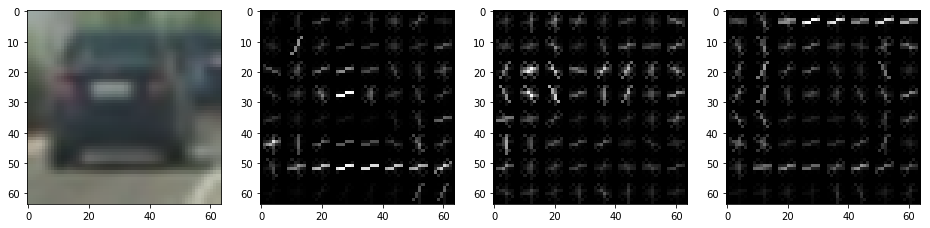

In [27]:
# Test HOG feature extraction
test_image = mpimg.imread('./data/vehicles/GTI_Far/image0000.png')
extractor = HogExtractor(test_image, visualise=True)
features = extractor.features()
hog_images = extractor.images()
print('HOG features shape: %s = 7x7x2x2x9x3' % features.shape)
figure = plt.figure(figsize=(16, 4))
plt.subplot(141)
plt.imshow(test_image)
imsave('hog_extractor_car.jpg', test_image)
plt.subplot(142)
plt.imshow(hog_images[0], cmap='gray')
imsave('hog_extractor_car_luv_channel1.jpg', hog_images[0])
plt.subplot(143)
plt.imshow(hog_images[1], cmap='gray')
imsave('hog_extractor_car_luv_channel2.jpg', hog_images[1])
plt.subplot(144)
plt.imshow(hog_images[2], cmap='gray')
imsave('hog_extractor_car_luv_channel3.jpg', hog_images[2])

### 1.3 Test Extractor on Part of an Image
Later this will be used for extracting HOG features when doing sliding window search.

(810, 380)
(950, 520)
(720, 1280)


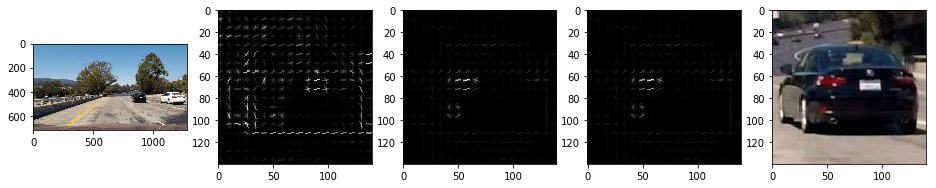

In [49]:
test_image = imread('test_images/test1.jpg')
extractor = HogExtractor(test_image, visualise=True)
window = ((810, 380), (950, 520))
features = extractor.window_features(window)
hog_images = extractor.window_images(window)
figure = plt.figure(figsize=(16, 4))
plt.subplot(151)
plt.imshow(test_image)
imsave('hog_extractor_video.jpg', test_image)
plt.subplot(152)
plt.imshow(hog_images[0], cmap='gray')
imsave('hog_extractor_video_luv_channel1.jpg', hog_images[0])
plt.subplot(153)
plt.imshow(hog_images[1], cmap='gray')
imsave('hog_extractor_video_luv_channel2.jpg', hog_images[1])
plt.subplot(154)
plt.imshow(hog_images[1], cmap='gray')
imsave('hog_extractor_video_luv_channel3.jpg', hog_images[2])
plt.subplot(155)
plt.imshow(crop_image(test_image, window), cmap='gray')
imsave('hog_extractor_video_cropped.jpg', crop_image(test_image, window))


## 2. Read Dataset
### 2.1 Process Images

In [17]:
car_image_paths = glob.glob('./data/vehicles/**/*.png')
notcar_image_paths = glob.glob('./data/non-vehicles/**/*.png')
print('Car images: %d, not-car images: %d' % (len(car_image_paths), len(notcar_image_paths)))

def extract_features(image_path):
    return HogExtractor(imread(image_path)).features()

# Use multiple cores to process images
%time car_features = np.vstack(multiprocessing(extract_features, car_image_paths))
%time notcar_features = np.vstack(multiprocessing(extract_features, notcar_image_paths))

Car images: 8792, not-car images: 8968
CPU times: user 2.72 s, sys: 866 ms, total: 3.58 s
Wall time: 11.8 s
CPU times: user 2.72 s, sys: 902 ms, total: 3.62 s
Wall time: 11.1 s


### 2.2 Generate Data Set and Normalize

In [18]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
print('X shape: %s, y shape: %s' % (X.shape, y.shape))

X shape: (17760, 5292), y shape: (17760,)


### 2.3 Split Training and Test Set

In [19]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2)
print('Training: X shape: %s, y shape: %s' % (X_train.shape, y_train.shape))
print('Testing: X shape: %s, y shape: %s' % (X_test.shape, y_test.shape))

Training: X shape: (14208, 5292), y shape: (14208,)
Testing: X shape: (3552, 5292), y shape: (3552,)


## 3 Training SVM

In [20]:
svc = SVC()
%time svc.fit(X_train, y_train)

CPU times: user 3min 4s, sys: 653 ms, total: 3min 5s
Wall time: 3min 7s


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [21]:
print('Train Accuracy of SVC = ', round(svc.score(X_train, y_train), 4))
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Train Accuracy of SVC =  0.9996
Test Accuracy of SVC =  0.9927


## 4 Using Different Color Space

In [12]:
color_spaces = ['RGB', 'HSV', 'LUV', 'YCrCb']
for color_space in color_spaces:
    def extract_features(image_path):
        return HogExtractor(imread(image_path), color_space=color_space).features()
    car_features = np.vstack(multiprocessing(extract_features, car_image_paths))
    notcar_features = np.vstack(multiprocessing(extract_features, notcar_image_paths))
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2)
    svc = SVC()
    svc.fit(X_train, y_train)
    print('Color space: %s: Train Accuracy of SVC = ' % color_space, round(svc.score(X_train, y_train), 4))
    print('Color space: %s: Test Accuracy of SVC = ' % color_space, round(svc.score(X_test, y_test), 4))

Color space: RGB: Train Accuracy of SVC =  0.9991
Color space: RGB: Test Accuracy of SVC =  0.9916
Color space: HSV: Train Accuracy of SVC =  0.9996
Color space: HSV: Test Accuracy of SVC =  0.9927
Color space: LUV: Train Accuracy of SVC =  0.9995
Color space: LUV: Test Accuracy of SVC =  0.9947
Color space: YCrCb: Train Accuracy of SVC =  0.9996
Color space: YCrCb: Test Accuracy of SVC =  0.9938


## 5 Sliding Window
### 5.1 Generate Windows

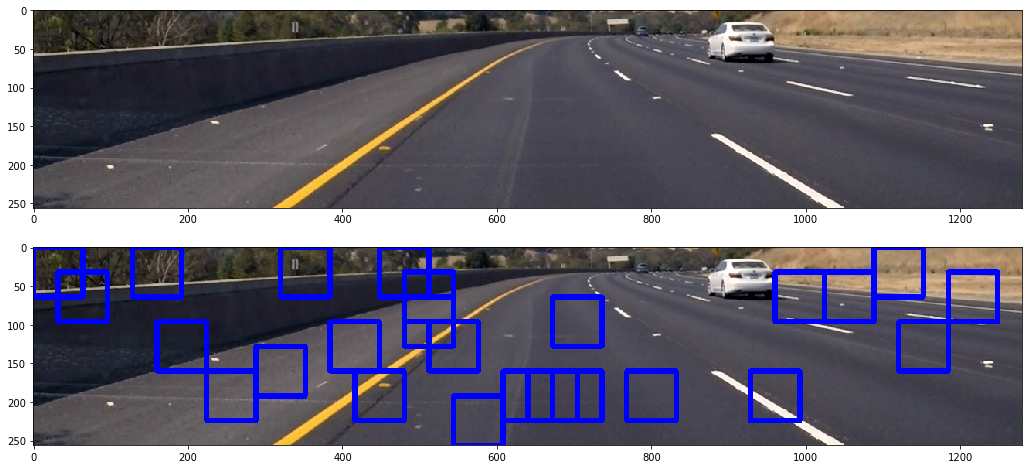

In [87]:
def slide_window(image_shape,
                 x_start_stop=(None, None),
                 y_start_stop=(None, None),
                 xy_window=(64, 64),
                 xy_overlap=(32, 32)):
    window_list = []
    x_start = 0 if x_start_stop[0] is None else x_start_stop[0]
    x_stop = image_shape[1] if x_start_stop[1] is None else x_start_stop[1]
    y_start = 0 if y_start_stop[0] is None else y_start_stop[0]
    y_stop = image_shape[0] if y_start_stop[1] is None else y_start_stop[1]
    x_len = xy_window[0]
    y_len = xy_window[1]
    x_overlap = xy_overlap[0]
    y_overlap = xy_overlap[1]
    for i in range(0, int(((x_stop - x_start) / x_len - 1) / x_overlap * x_len + 1)):
        for j in range(0, int(((y_stop - y_start) / y_len - 1) / y_overlap * x_len + 1)):
            window = (
                (x_start + int(i * x_overlap), y_start + int(j * y_overlap)),
                (x_start + int(i * x_overlap) + x_len, y_start + int(j * y_overlap) + y_len),
                )
            window_list.append(window)
    return window_list

# Copied from Udacity course material
def draw_boxes(image, bboxes, color=(0, 0, 255), thick=6):
    image_copy = np.copy(image)
    for bbox in bboxes:
        cv2.rectangle(image_copy, bbox[0], bbox[1], color, thick)
    return image_copy

test_image = mpimg.imread('test_images/test3.jpg')
test_image = test_image[400:656,:,:]
window_list = slide_window(test_image.shape)
# Showing random boxes
window_list = subsample(window_list, probability=0.1)
test_image_with_boxes = draw_boxes(test_image, window_list)
figure = plt.figure(figsize=(32, 8))
plt.subplot(211)
plt.imshow(test_image)
plt.subplot(212)
plt.imshow(test_image_with_boxes)
imsave('generate_windows.jpg', test_image_with_boxes)

### 5.2 Predict Window Image

Whether this window contains a car: True


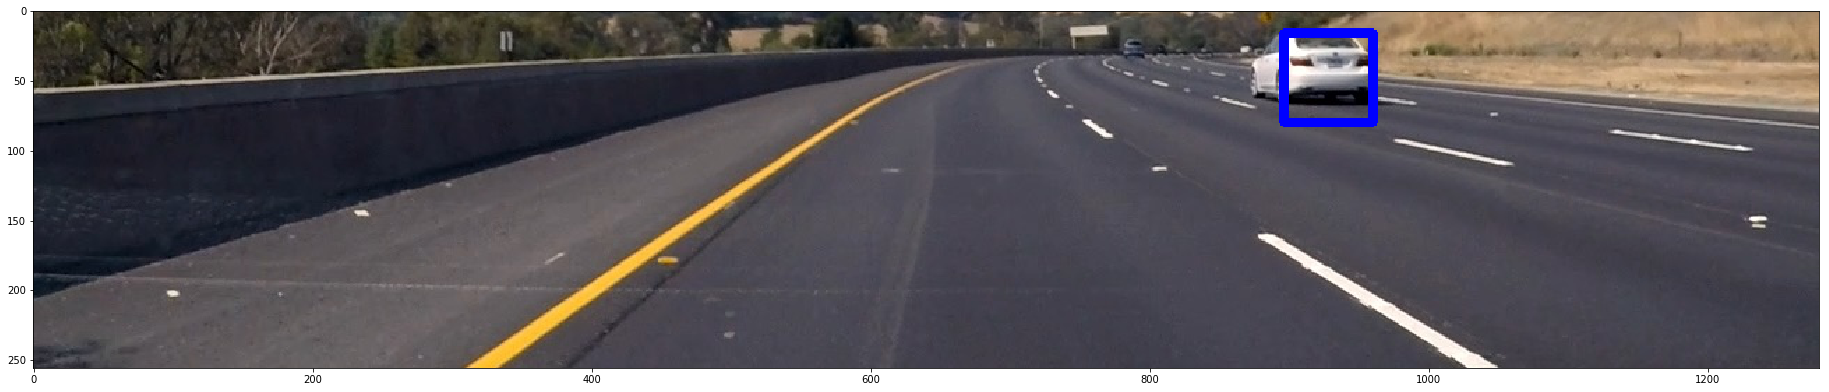

In [33]:
test_image = imread('test_images/test3.jpg')[400:656,:,:]
hog_extractor = HogExtractor(test_image)
window = ((896, 16), (960, 80))

def predict_window(hog_extractor, window):
    hog_features = hog_extractor.window_features(window).reshape(1, -1)
    scaled_hog_features = X_scaler.transform(hog_features)
    return svc.predict(scaled_hog_features)[0] > 0.5

test_image_with_car_box = draw_boxes(test_image, [window])
plt.figure(figsize=(32, 8))
plt.imshow(test_image_with_car_box)
imsave('predict_window_image.jpg', test_image_with_car_box)

print('Whether this window contains a car: %s' % ('True' if predict_window(hog_extractor, window) else 'False'))

### 5.3 Predict Window Image with Scale

[((640, 0), (800, 160)), ((720, 0), (880, 160)), ((800, 0), (960, 160))]
Whether the first window contains a car: False
Whether the second window contains a car: False
Whether the third window contains a car: True


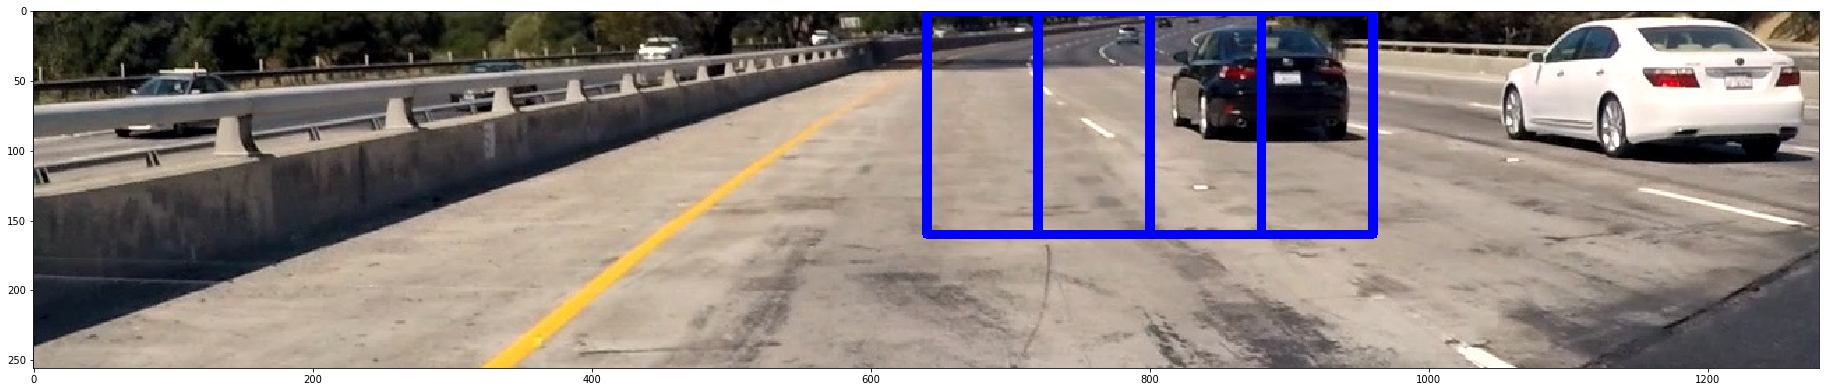

In [37]:
# Scale image size to size/scale (equivalent to scaling window to size*scale).
def scale_down_image(image, scale):
    image_shape = image.shape
    return cv2.resize(image, (np.int(image_shape[1] / scale), np.int(image_shape[0] / scale)))

def scale_up_window(window, scale):
    
    def multiply(num, scale):
        return int(num * scale)
    
    return ((multiply(window[0][0], scale), multiply(window[0][1], scale)),
            (multiply(window[1][0], scale), multiply(window[1][1], scale)))

def scale_up_windows(window_list, scale):
    return list(map(lambda window: scale_up_window(window, scale), window_list))

scale = 2.5
window_list = [((256, 0), (320, 64)), ((288, 0), (352, 64)), ((320, 0), (384, 64))]
print(list(scale_up_windows(window_list, scale)))
test_image = imread('test_images/test1.jpg')[400:656,:,:]
test_image_with_scaled_up_windows = draw_boxes(test_image, scale_up_windows(window_list, scale))
plt.figure(figsize=(32,8))
plt.imshow(test_image_with_scaled_up_windows)
imsave('predict_scaled_up_window_image.jpg', test_image_with_scaled_up_windows)

hog_extractor = HogExtractor(scale_down_image(test_image, scale))
print('Whether the first window contains a car: %s' % ('True' if predict_window(hog_extractor, window_list[0]) else False))
print('Whether the second window contains a car: %s' % ('True' if predict_window(hog_extractor, window_list[1]) else False))
print('Whether the third window contains a car: %s' % ('True' if predict_window(hog_extractor, window_list[2]) else False))


### 5.4 Searching Windows with Multiple Scales

CPU times: user 10.1 s, sys: 55.7 ms, total: 10.2 s
Wall time: 10.4 s


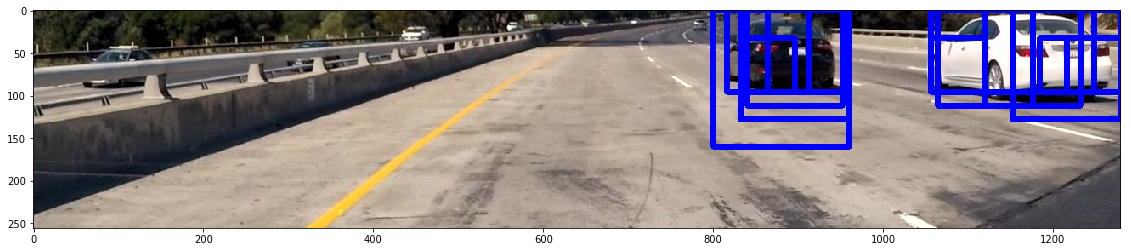

In [39]:
test_image = imread('test_images/test1.jpg')[400:656,:,:]

def sliding_window_search(image):
    scales = [1, 1.25, 1.5, 1.75, 2, 2.25, 2.5]
    windows_found = []
    for scale in scales:
        scaled_image = scale_down_image(image, scale)
        hog_extractor = HogExtractor(scaled_image)
        window_list = slide_window(scaled_image.shape)
        positive_window_list = filter(lambda window: predict_window(hog_extractor, window), window_list)
        scaled_positive_window_list = list(map(lambda window: scale_up_window(window, scale), positive_window_list))
        windows_found.extend(scaled_positive_window_list)
    return windows_found

%time windows = sliding_window_search(test_image)
figure = plt.figure(figsize=(20, 4))
test_image_with_predicted_car_windows = draw_boxes(test_image, windows)
plt.imshow(test_image_with_predicted_car_windows)
imsave('predict_windows_multiple_scales.jpg', test_image_with_predicted_car_windows)

## 6 Bounding Boxes
### 6.1 Heatmap

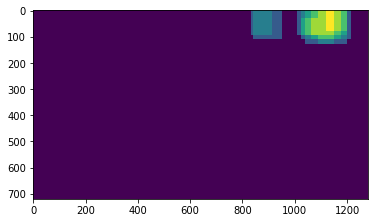

In [81]:
def draw_heatmap(image, windows, threshold=1):
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    for window in list(windows):
        heatmap[window[0][1]:window[1][1], window[0][0]:window[1][0]] += 1
    heatmap[heatmap <= threshold] = 0
    return np.clip(heatmap, 0, 255)

heatmap = draw_heatmap(test_image, windows)
plt.imshow(heatmap)
imsave('predict_windows_heatmap.jpg', heatmap)

### 6.2 Label and Draw Bounding Boxes

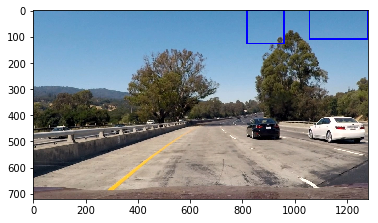

In [56]:
def get_bounding_boxes(heatmap):
    labels = label(heatmap)
    boxes = []
    for car_number in range(1, labels[1] + 1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        boxes.append(((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy))))
    return boxes

test_image_bounding_boxes = draw_boxes(test_image, get_bounding_boxes(heatmap))
plt.imshow(test_image_bounding_boxes)
imsave('predict_windows_bounding_boxes.jpg', test_image_bounding_boxes)

## 7 Cropping
A helper class to deal with logic related to cropping image

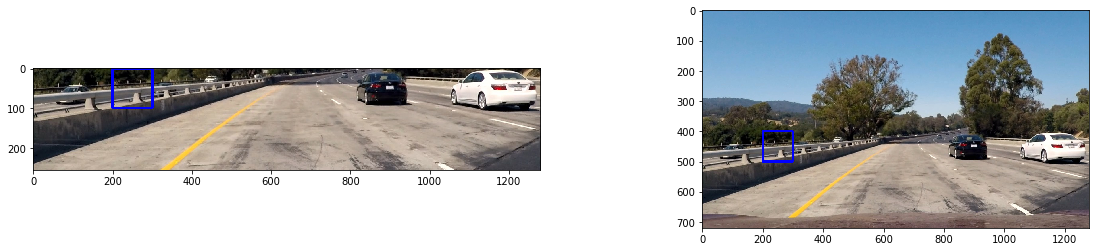

In [88]:
class CroppedImage:
    def __init__(self, image, y_start=400, y_end=656):
        self.y_start = y_start
        self.original = image
        self.cropped = image[y_start:y_end, :, :]
    
    def original_boxes(self, boxes):
        return list(map(lambda box: ((box[0][0], box[0][1] + self.y_start),
                                     (box[1][0], box[1][1] + self.y_start)),
                        boxes))

image = CroppedImage(imread('test_images/test1.jpg'))
box = ((200, 0), (300, 100))

plt.figure(figsize=(20, 4))
plt.subplot(121)
plt.imshow(draw_boxes(image.cropped, [box]))
plt.subplot(122)
plt.imshow(draw_boxes(image.original, image.original_boxes([box])))

## 8 Pipeline
### 8.1 Run on Test Images

In [91]:
def pipeline(image, previous_boxes=[]):
    cropped_image = CroppedImage(image)
    windows = sliding_window_search(cropped_image.cropped)
    windows.extend(previous_boxes)
    original_windows = cropped_image.original_boxes(windows)
    heatmap = draw_heatmap(image, original_windows)
    boxes = get_bounding_boxes(heatmap)
    return draw_boxes(image, boxes), boxes

# plt.figure(figsize=(20, 30))

# plt.subplot(211)
# output, windows = pipeline(imread('test_images/test5.jpg'))
# plt.imshow(output)

# plt.subplot(212)
# output, windows = pipeline(imread('test_images/test4.jpg'), windows)
# plt.imshow(output)

for i in range(1, 7):
    frame = frames[i + 10]
    cropped_image = CroppedImage(frame)
    windows = sliding_window_search(cropped_image.cropped)
    original_windows = cropped_image.original_boxes(windows)
    imsave('frame%d_sliding_window.jpg' % i, draw_boxes(frame, original_windows))
    heatmap = draw_heatmap(frame, original_windows)
    imsave('frame%d_heatmap.jpg' % i, heatmap)
    boxes = get_bounding_boxes(heatmap)
    image_with_boxes = draw_boxes(frame, boxes)
    imsave('frame%d_bounding_boxes.jpg' % i, image_with_boxes)

### 8.2 Run on Test Video

In [48]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def image_processor_generator():
    boxes = []
    frames = []
    def process_image(image):
        nonlocal boxes, frames
        output, windows = pipeline(image, boxes)
        frames.append(image)
        return output
    def get_frames():
        return frames
    return process_image, get_frames

def process_video(input_video_name, output_video_name):
    video_input = VideoFileClip(input_video_name)
    process_image, get_frames = image_processor_generator()
    video_output = video_input.fl_image(process_image)
    %time video_output.write_videofile(output_video_name, audio=False)
    return get_frames()

frames = process_video('test_video.mp4', 'test_video_output.mp4')


[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|█████████▋| 38/39 [06:37<00:10, 10.65s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 6min 22s, sys: 3.33 s, total: 6min 25s
Wall time: 6min 38s


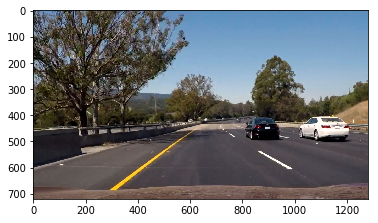

In [58]:
plt.imshow(frames[11])

### 8.3 Run on Project Video

In [ ]:
process_video('project_video.mp4', 'project_video_output.mp4')